In [1]:
from pylab import *
import random


# print out each line in the input cell not only the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# expand the cell width to 100% of t 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

*Gruppe: Tobias Blümlhuber, Silvan Kron, Simon Gärtner*

# Kleines Projekt 1: Zellulärer Automat
## Simulierung eines Waldbrandes 

Ein mögliches modell zur Simulation von Waldbränden basiert auf der Unterteilung einer Fläche in Zellen. Jeder der Zellen kann 3 Zustände annehmen: Baum, Feuer, leer. Nach bestimmten Update-Regeln verändert sie die Zellbelegung in jedem Zeitschritt. Ein solches modell nennt man zellulären Automaten.

Für einen solchen zellulären Automaten gilt:

- das untersuchte Gebiet wird in Zellen unterteil (zellulär)
- die Zellen können bestimmte Zustände annehmen (Zustand)
- die Zustände ändern sich nach gewissen Regeln pro Zeitschritt (Automat)

Zelluläre Automaten finden in vielen Simulationsbereichen Anwendung z.B. auch in der Verkehrssimulation.

**Updateregeln:**

Die Schlagkraft eines solchen Automaten steckt in den Updateregeln. Zunächst wird eine Anfangskonfiguration gesetzt, z.B. indem das Gebiet mit einer vom Anwender gegebenen Besetzungsdichte $b$ zufällig mit Bäumen bepflanzt wird.

Für jede Zelle wird während der Simulation in jedem Zeitschritt der Zustand nach dem folgenden Regeln neu bestimmt:

1. Ist eine Zelle leer, bleibt sie im nächsten Zeitschritt leer.
2. Falls sich in den 4 Nachbarzellen eines Baumes mindestens ein brennender Baum befindet, fängt der Baum mit der Wahrscheinlichkeit $p_e$ Feuer. Ein brennender Baum brennt innerhalb eines Zeitschrittes herunter, im nächsten Zeitschritt ist die Zelle auf jeden Fall leer.

**Aufgaben:**

1. Schreiben Sie ein SageMath-Programm, dass das obige einfache Waldbrandmodell umsetzt und grafisch darstellt. Die Gittergröße soll variabel sein.
2. Testen Sie anhand der Wahrscheinlichkeiten $p_e \in \{0.2, 0.5, 0.8\}$, wie sich das Feuer ausbreitet.
3. Implementieren Sie eine Statistikfunktion, die (z.B. für ein 20 x 20 Gitter) den Anteil des abgebrannten Waldes nach n Zeitschritten in Abhängigkeit von $p_e$ experimentell ermittelt (jeweils für 5 verschiedene Initialisierungen).
 -  Plotten Sie den Anteil des abgebrannten Waldes in Abhängigkeit von der Zeit.
 -  Stellen Sie den Anteil des abgebrannten Waldes in Abhängigkeit $p_e$ nach 10 Zeitschritten als Plot dar.
4. Wie behandeln Sie den Rand des Gebietes? Implementieren Sie einen weitere Möglichkeit und vergleichen Sie die Ergebnisse.
5. Nun soll noch die Möglichkeit eines Blitzeinschlages in einem baum mit der Wahrscheinlichkeit $p_b$ in das Modell aufgenommen werden. Vergleichen Sie mit Ihren bisherigen Ergebnissen.
6. Implementieren Sie *mindestens eine* der folgenden Modellerweiterungen und vergleichen Sie experimentell mit Ihren bisherigen Ergebnissen. Versuchen Sie Schlussfolgerungen zu finden:
  -  Ein Baum benötigt zum Abbrennen 2 Zeitschritte.
  -  Die Wahrscheinlichkeit es Baumes, Feuer zu fangen, steigt mit der Anzahl der brennenden Bäume in der Umgebung.
  - In einer leeren Zelle wächst mit der Wahrscheinlichkeit $p_n$ ein neuer Baum. 
  - Die Größe eines Baumes ändert sich von Zeitschritt zu Zeitschritt, ein großer Baum benötigt mehr Zeit zum Abbrennen.
  -  Berücksichtigen Sie Wind-Richtung (N, O, S, W) und -Geschwindigkeit (klein, mittel, hoch)

**Arbeitsschritt 1:**

In diesem Codeabschnitt werden verschiedenste Parameter für den Zellulären Automaten definiert:

- `number_of_columns` definiert die Spaltenanzahl des Gitternetzes
- `number_of_rows` definiert die Zeilenanzahl des Gitternetzes
- `density` definiert die Dichte der Bäume (in Prozent, z.B. 80% der Fläche sind mit Bäumen besetzt -> 0.80)
- `pe` definiert die Wahrscheinlichkeit, dass ein Baum durch einen brennenden Nachbarbaum Feuer fängt
- `pb` definiert die Wahrscheinlichkeit, dass ein Baum durch einen Blitz getroffen wird
- `pw` definiert die Wahrscheinlichkeit, dass auf einem leeren Feld ein Baum nachwächst

Des Weiteren werden Listen erstellt für jede Kategorie, die ein Feld einnehmen kann (`forest_fields` - Felder mit Bäumen, `fire_fields` - Felder auf denen ein Feuer ist, `free_fields` - Felder auf denen weder ein Feuer noch ein Baum ist).

Ebenso wird die Matrix `forest` definiert. Diese dient als Grundlage für das Gitternetz des Automaten. Diese wird initizial mit Nullen befüllt.

Anschließend wird die Liste `free_fields` mit allen vorhandenen Koordinaten befüllt. Hierbei handelt es sich immer um ein Tupel, das zuerst die Zeile beinhaltet und als zweites die Spalte.

In [2]:
# define parameters for grid layout
number_of_columns = 20
number_of_rows = 20

# density of trees in the grid
density = 0.8

# possibility for fire
pe = 0.5 

# possibility for lighting
pb = 0

# possibility for a new tree
pw = 0

# define lists for each category
forest_fields = []
fire_fields = []
free_fields = []


# create forest matrix
forest = random_matrix(ZZ, nrows = number_of_rows, ncols = number_of_columns, x = 1)

# fill list with free fields with all possible values -> forest has no trees
for col in range(0, number_of_columns):
    for row in range(0, number_of_rows):
        free_fields.append((row, col))

**Arbeitsschritt 2: Erstellen von Methoden und durchführen der Simulation**

Die Methode `printMatrix(forest)` plotet die übergebene Matrix `forest`. Dabei gibt es folgende farbliche Unterteilung:
- leeres Feld: weiß
- Feld mit Baum: grün
- brennendes Feld: rot

Die Einteilung ob ein Feld leer ist, einen Baum beinhaltet oder ein Feuer hat beruht auf den Werten in der Matrix. Dafür wurde folgende Wertezuweisung vorgenommen:
- -1: Feuer
- 0: leeres Feld
- 1: Feld mit Baum

In [3]:
def printMatrix(forest):
    # define colors
    color_pool = ['#FF0000', '#FFFFFF', '#006400' ]

    # convert colors to color map
    color_map = matplotlib.colors.ListedColormap(color_pool[0:3])

    # return matrix plot
    return matrix_plot(forest, cmap = color_map, colorbar = True, vmin = -1, vmax = 1)

Die Methode `createTree(coordinates, forest, forest_fields, free_fields)` wird dazu benötigt, um an den übergebenen Koordinaten einem Baum zu erstellen. Im gleichen Zug wird auch dieses Feld aus den leeren Feldern entfernt.

In [4]:
def createTree(coordinates, forest, forest_fields, free_fields):
    
    # set matrix value
    forest[coordinates[0], coordinates[1]] = 1
    
    # add to forest list 
    forest_fields.append(coordinates)
    
    # remove from free fields list
    free_fields.remove(coordinates)

Die Methode `createFire(coordinates, forest, forest_fields, fire_fields)` wird dazu benötigt, um an den übergebenen Koordinaten ein Feuer zu zünden. Ebenso wird auch hier gleich die Liste mit Bäumen angepasst.

In [5]:
def createFire(coordinates, forest, forest_fields, fire_fields):
    
    # set matrix value
    forest[coordinates[0], coordinates[1]] = -1
    
    # remove from forest
    forest_fields.remove(coordinates)
    
    # add to fire list
    fire_fields.append(coordinates)

Die Methode `createEmptyField(coordinates, forest, free_fields)` wird dazu benötigt, um an den übergebenen Koordinaten ein leeres Feld erstellen.

In [6]:
def createEmptyField(coordinates, forest, free_fields):
    
    # set matrix value
    forest[coordinates[0], coordinates[1]] = 0
    
    # add to free fields list
    free_fields.append(coordinates)

Die Methode `createTrees(density, free_fields, forest_fields, number_of_cols, number_of_rows, forest)` wird dazu benötigt um das Gitternetz initial zufällig mit Bäumen zu befüllen. Die Anzahl der Bäume richtet sich dabei nach dem in `density` festgelegten Prozentwert. 

Zuerst wird hierfür die Anzahl der Bäume errechnet (`number_of_trees`). 

Anschließend wird zufällig aus den leeren Feldern Felder entnommen und auf ihnen ein Baum erzeugt. Hierfür werden die bereits oben definierten Methoden verwendet.

In [7]:
def createTrees(density, free_fields, forest_fields, number_of_cols, number_of_rows, forest):
    
    # calculate amount of trees based on the density
    number_of_trees = number_of_cols * number_of_rows * density
    
    # create the amount of trees randomly
    while (number_of_trees > 0):
        
        # get a random index
        index = random.randint(0, len(free_fields)-1)

        # get the coordinates
        coordinates = free_fields[index]

        # create tree
        createTree(coordinates, forest, forest_fields, free_fields)
        number_of_trees -= 1


Die Methode `createInitialFire(forest_fields, fire_fields, forest)` erstellt das erste Feuer. Dieses wird zufällig aus den Feldern mit Bäumen ausgewählt und entzündet.

In [8]:
def createInitialFire(forest_fields, fire_fields, forest):
    
    # get random index from forest list
    index = random.randint(0, len(forest_fields)-1)
    
    # get coordinates
    coordinates = forest_fields[index]
    
    # create fire
    createFire(coordinates, forest, forest_fields, fire_fields)

Die folgende Methode `spreadFire(forest_fields, fire_fields, free_fields, pe, forest, oneSystem, amount_of_cols, amount_of_rows)` sorgt dafür, dass sich das Feuer ausbreiten kann. Hierfür werden zuerst alle bestehenden Brände durchgangen und die umliegenden Felder ermittelt. Wenn auf diesen ein Baum steht kommen sie in die engere Auswahl. 

In einem weiteren Schritt wird dann, aus den Bäumen die in Gefahr sind, die Anzahl für neue Feuer ermittelt. Dies basiert auf der festgelegten Wahrscheinlichkeit für ein neues Feuer (`pe`).

Diese Felder werden dann wieder zufällig aus den möglichen neuen Bränden entnommen und mit der Hilfsmethode `createFire` entzündet.

**Arbeitsschritt 4 - Weitere Implementierung für Randfelder**

Wenn `oneSystem` wahr ist wird eine andere Behandlung der Randfelder vorgenommen. 

Diese funktioniert wir folgt:

Ein Baum in Zeile 0 und Spalte 2 kann nicht nur den unteren, den linken und den rechten Baum entzünden, sonder auch den Baum auf der anderen Seite des Gitters. In diesem Fall den Baum in der maximalen Zeile und Spalte 2. Hier für geschaut ob eines der Felder, die das Feuer umgeben außerhalb des Gitter liegen und wenn ja angepasst, dass diese auf ein Feld am gegenüberliegenden Gitterrand zeigen.
Dies gilt nicht nur von oben nach unten und anderes herum, sonder auch für von links nach rechts und von rechts nach links.

Wenn `oneSystem` nicht wahr ist, dann werden die Ränder ganz normal behandelt.

In [9]:
def spreadFire(forest_fields, fire_fields, free_fields, pe, forest, oneSystem, amount_of_cols, amount_of_rows):
    
    # copy fire fields
    temp = fire_fields.copy()
    

    # reset fire list
    fire_fields.clear()
    
    # create list for possible fires 
    possible_fire_fields = []
    
    # loop through all fires
    for fire in temp:
        
        # get fields around fire field
        top_field = (fire[0]-1, fire[1])
        bottom_field = (fire[0]+1, fire[1])
        right_field = (fire[0], fire[1]+1)
        left_field = (fire[0], fire[1]-1)      
        
        # switch to enable a different implementation for border fields 
        # -> function: a field in row 0 and column 2, 
        # can create a fire in row max_row and column 2, also vice versa
        # and from the left side to the right side
        
        if oneSystem:
            
            # check if possible field is besides the border
            # if yes -> adjust coordinates to the other side
            # if no -> do nothing
            
            if left_field[1] < 0:
                left_field = (left_field[0], amount_of_cols-1)
         
            if right_field[1] == amount_of_cols:
                right_field = (right_field[0], 0)
                
            if top_field[0] < 0:
                top_field = (amount_of_rows-1, top_field[1])
            
            if bottom_field[0] == amount_of_rows:
                bottom_field = (0, bottom_field[1])
              
        # check if possible field is a fire field and is not allready in the
        # possible fire fields list
        # if yes -> add to possible fire fields list
        # if no -> do nothing
        
        if left_field in forest_fields and left_field not in possible_fire_fields:
            possible_fire_fields.append(left_field)
        
        if right_field in forest_fields and right_field not in possible_fire_fields:
            possible_fire_fields.append(right_field)
            
        if top_field in forest_fields and top_field not in possible_fire_fields:
            possible_fire_fields.append(top_field)
        
        if bottom_field in forest_fields and bottom_field not in possible_fire_fields:
            possible_fire_fields.append(bottom_field)
 
        createEmptyField(fire, forest, free_fields)
    
    # calculate the amount of new fire fields based on the possiblity for a new fire
    number_of_new_fires = len(possible_fire_fields) * pe
    
    # create the correct amount of fires
    while(number_of_new_fires > 0):
        
        # pick a random index out of the possible fire fields list
        index = random.randint(0, len(possible_fire_fields)-1)
        
        # get coordinates
        new_fire = possible_fire_fields[index]
        
        # create fire
        createFire(new_fire, forest, forest_fields, fire_fields)
        
        # remove from possible fire list
        possible_fire_fields.remove(new_fire)
        
        number_of_new_fires -= 1
    
    # clear possible fire list for the next run
    possible_fire_fields.clear()


**Arbeitsschritt 5 - Blitzeinschlag**

Die Methode `createLightningFire()` entzündet mit der Wahrscheinlichkeit `pb` einen Baum durch einen Blitz.

In [10]:
def createLightningFire(forest_fields, fire_fields, free_fields, pb):
    
    # calculate the amount of fires through lighting based on the possibility for a lighting
    number_lightning_strikes = len(forest_fields) * pb
    
    # create the right amount of fires
    while(number_lightning_strikes > 0):
        
        # pick a random index out of the forest list
        index = random.randint(0, len(forest_fields)-1)
        
        # get coordinates
        new_fire = forest_fields[index]
        
        # create a fire
        createFire(new_fire, forest, forest_fields, fire_fields)
        number_lightning_strikes -= 1

**Arbeitsschritt 6 - Erweiterungen**

Die Methode `growTree` lässt mit einer gewählten Wahrscheinlichkeit Bäume auf leeren Feldern wachsen.

In [11]:
def growTree(pw, free_fields, forest_fields, forest):
    
    # calculate the right amount of new trees based on the possibility for a new tree
    number_of_trees = len(free_fields) * pw
    
    # create the right amount of new trees
    while(number_of_trees > 0):
        
        # pick a random index out of the free fields list
        index = random.randint(0, len(free_fields)-1)
        
        # get the coordinates
        coordinates = free_fields[index]
    
        # create a tree
        createTree(coordinates, forest, forest_fields, free_fields)
        number_of_trees -= 1

**MAIN PROGRAMM**

Dieser Codeblock lässt die Simulation einmal durchlaufen und gibt nach jedem Zeitschritt den aktuellen Stand als Plot aus. Hierfür wird zuerst ein Setup erstellt und anschließen bis keine Bäume mehr verfügbar sind, keine Feuer mehr vorhanden ist oder die Obergrenze von 100 Zeiteinheiten erreicht ist durchgeführt.

Die Obergrenze von 100 Zeiteinheiten wurde festgelegt, da sonst die Möglichkeit für eine endlos Schleife besteht, wenn die Bäume im gleichen Tempo nachwachsen und verbrennen.

Start scene:


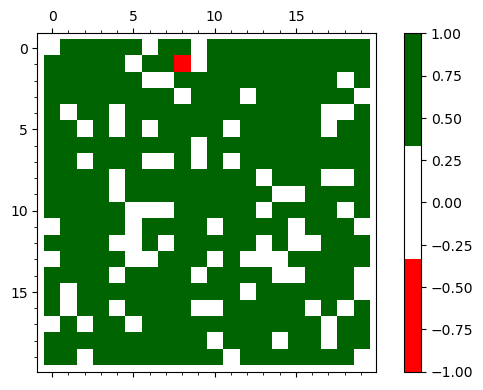

Current time: 1


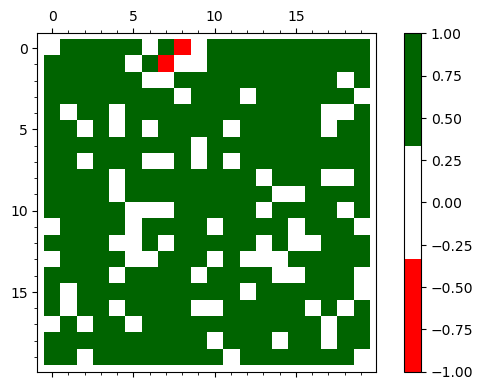

Current time: 2


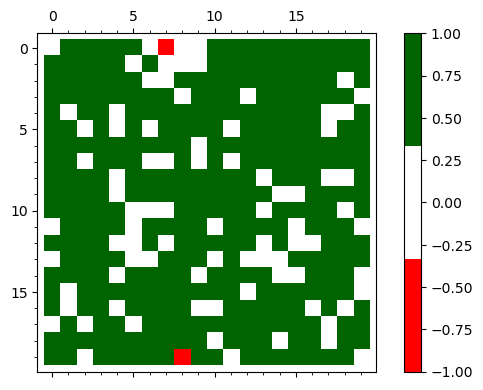

Current time: 3


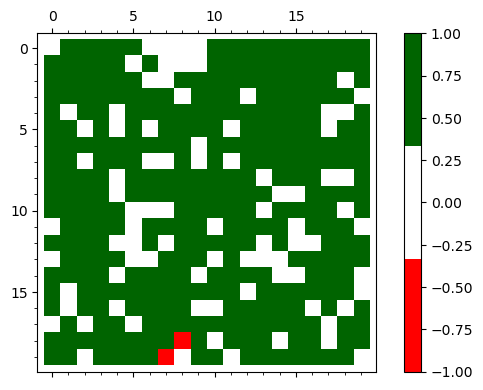

Current time: 4


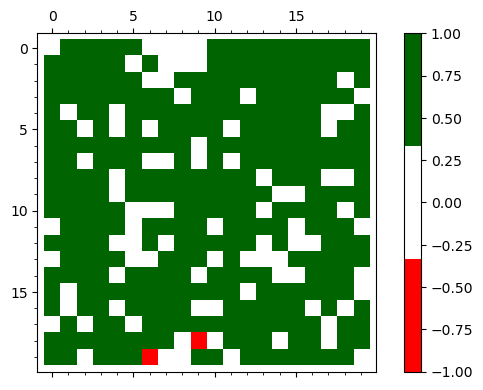

Current time: 5


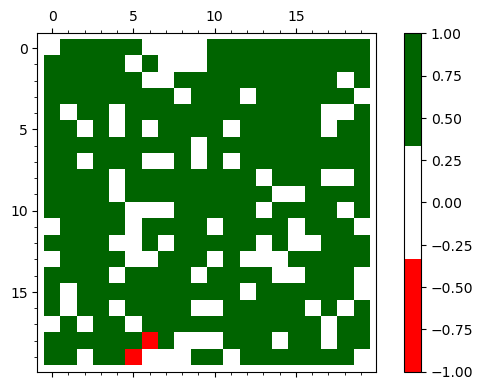

Current time: 6


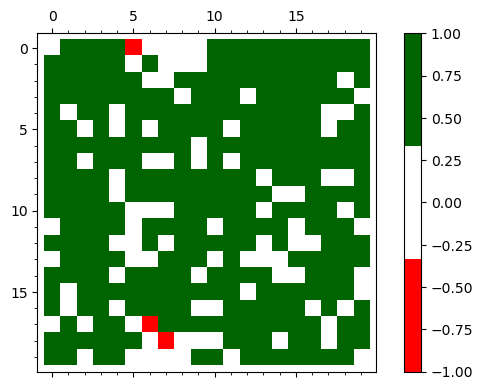

Current time: 7


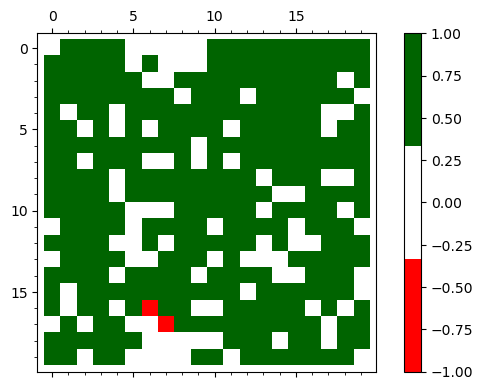

Current time: 8


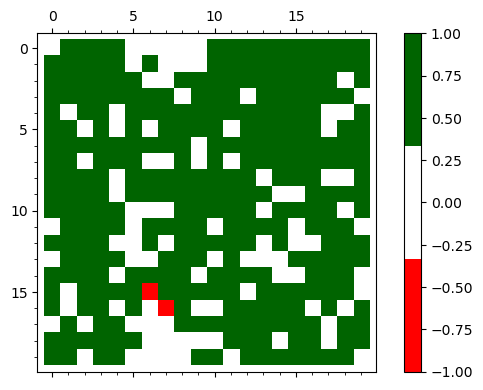

Current time: 9


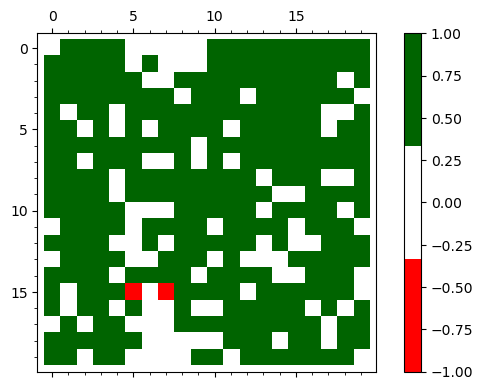

Current time: 10


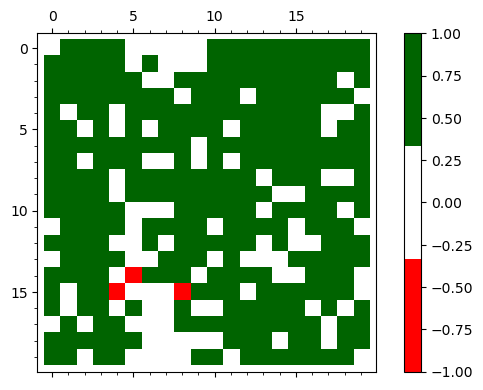

Current time: 11


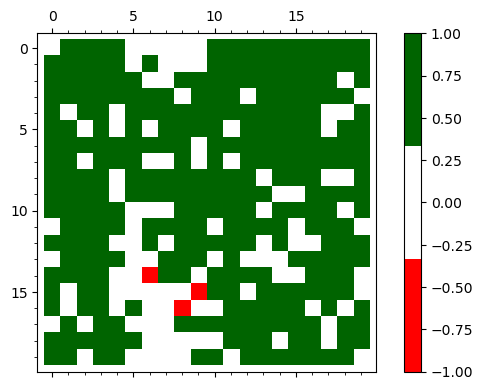

Current time: 12


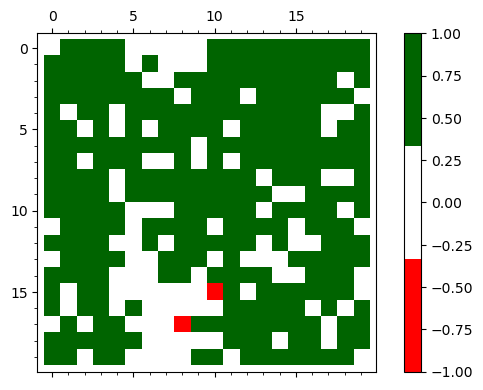

Current time: 13


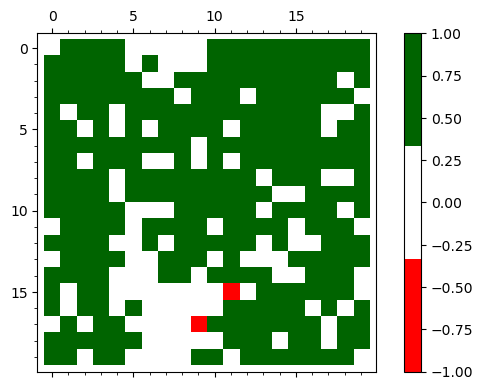

Current time: 14


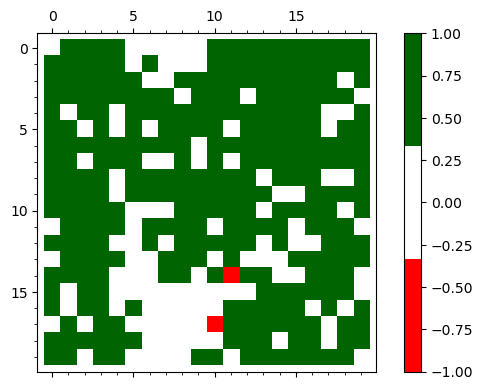

Current time: 15


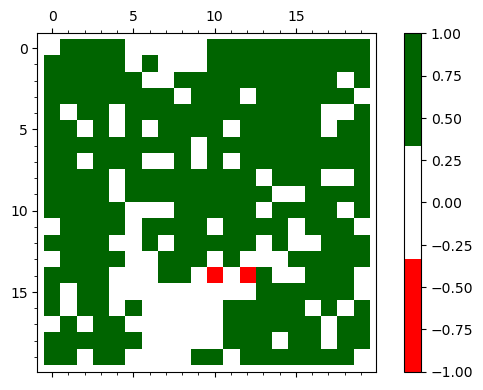

Current time: 16


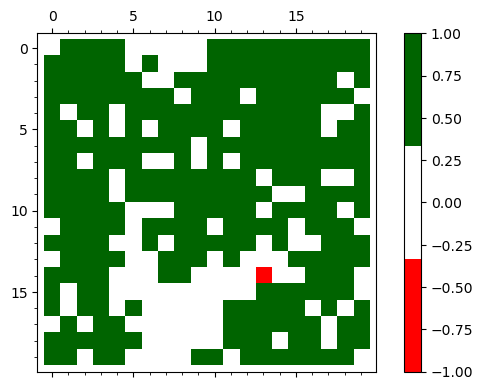

Current time: 17


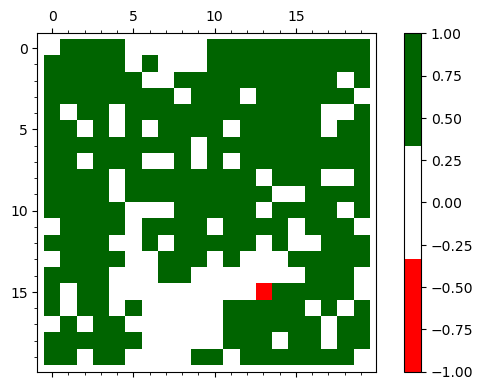

Current time: 18


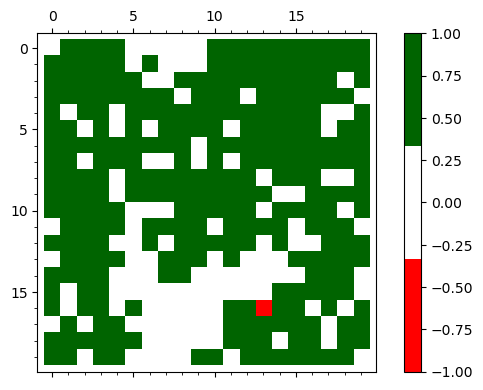

Current time: 19


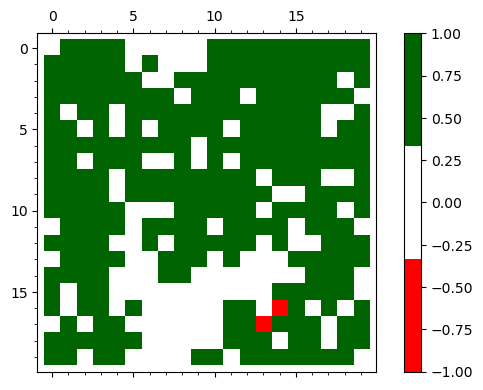

Current time: 20


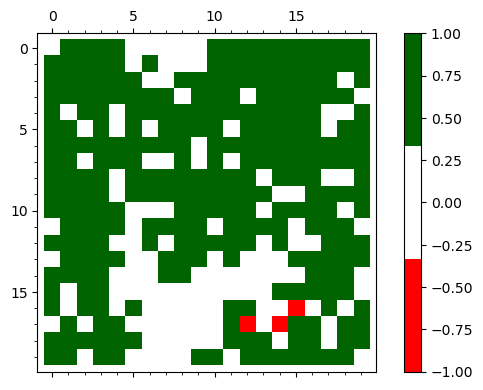

Current time: 21


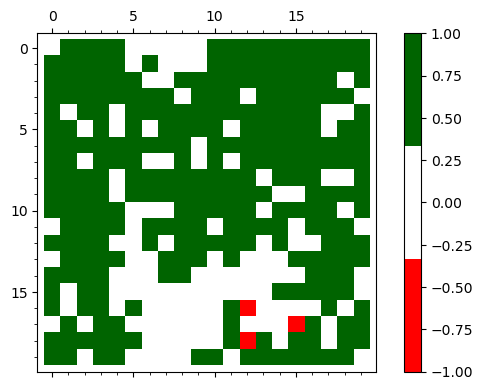

Current time: 22


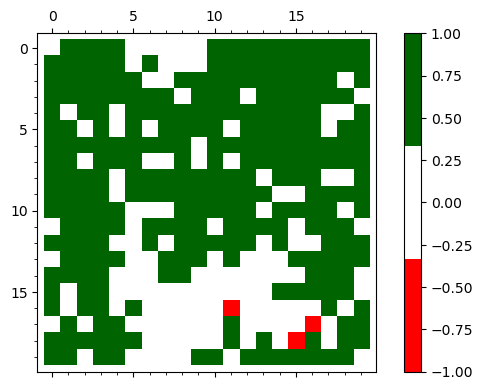

Current time: 23


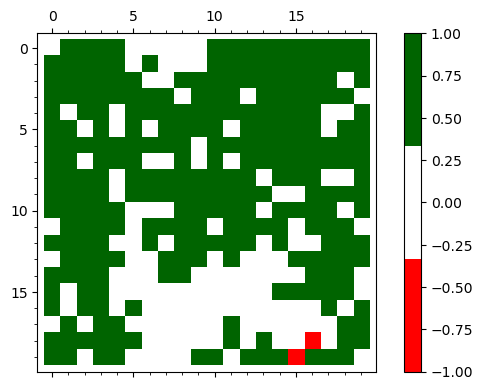

Current time: 24


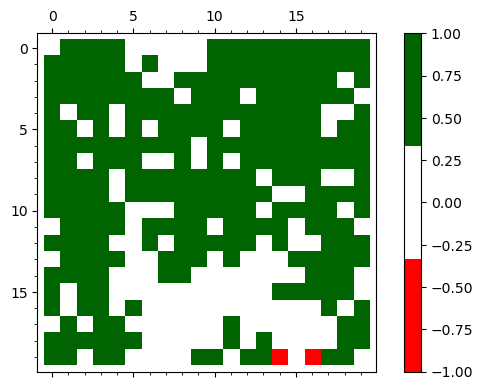

Current time: 25


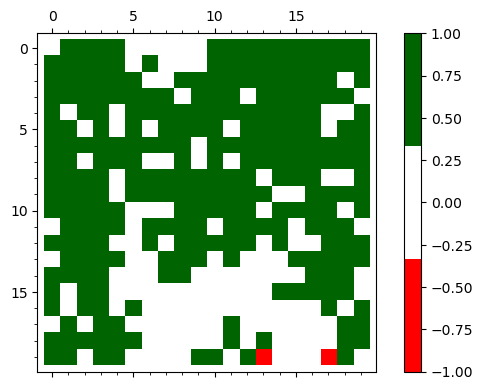

Current time: 26


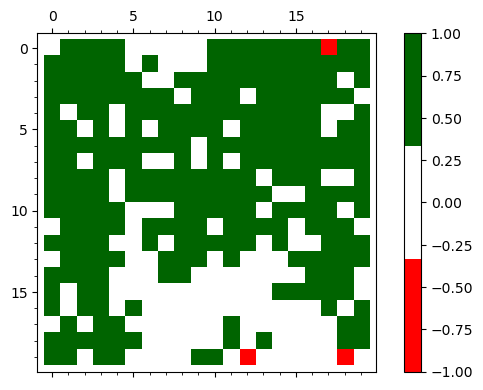

Current time: 27


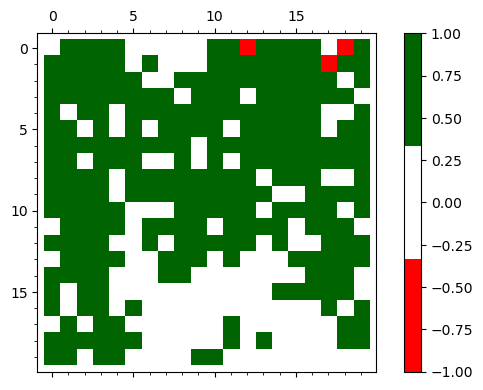

Current time: 28


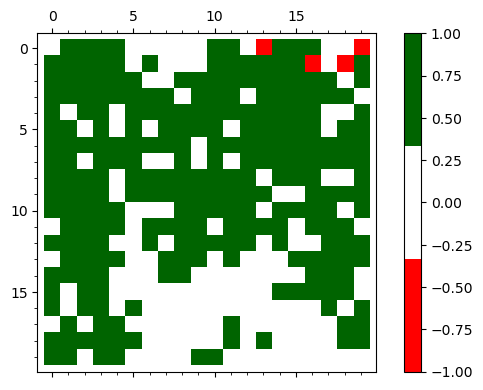

Current time: 29


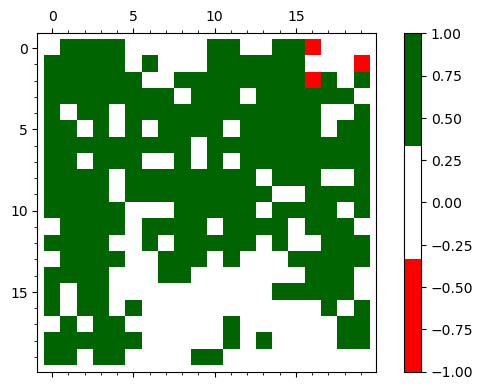

Current time: 30


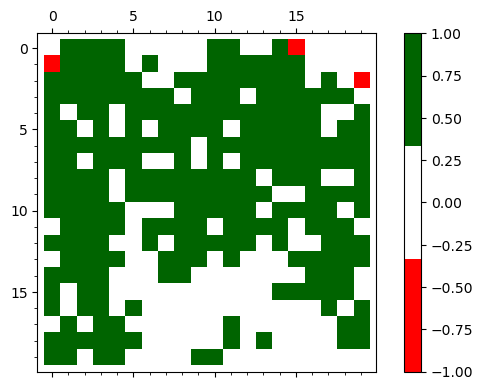

Current time: 31


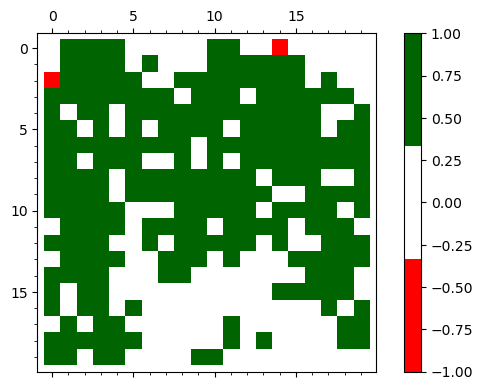

Current time: 32


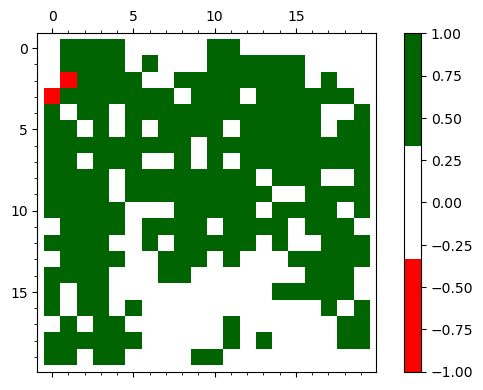

Current time: 33


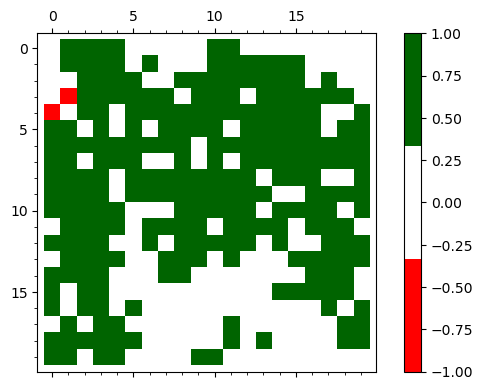

Current time: 34


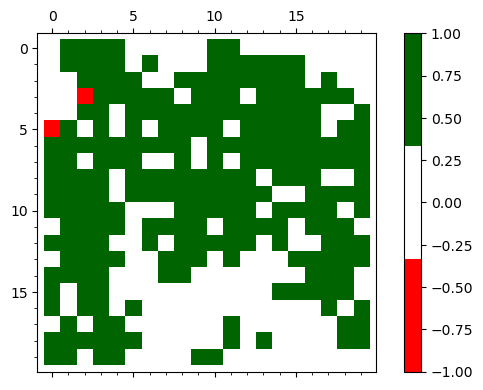

Current time: 35


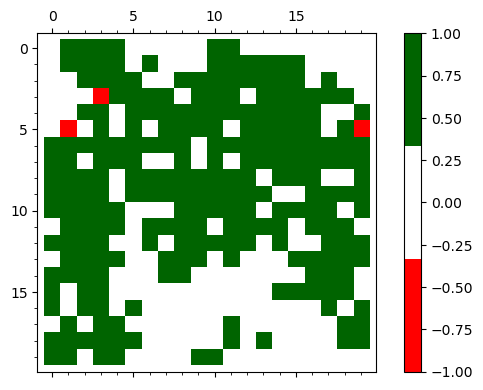

Current time: 36


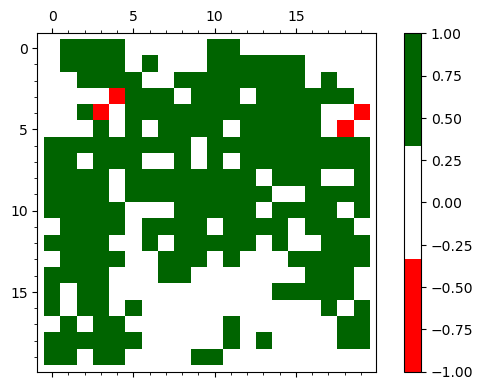

Current time: 37


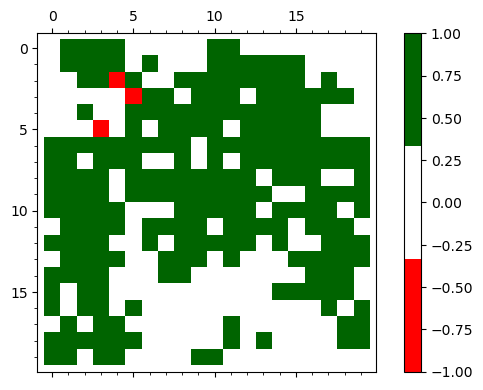

Current time: 38


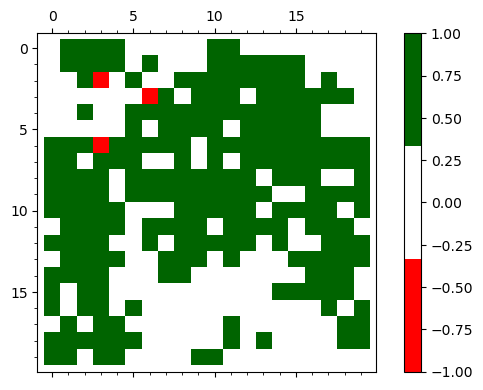

Current time: 39


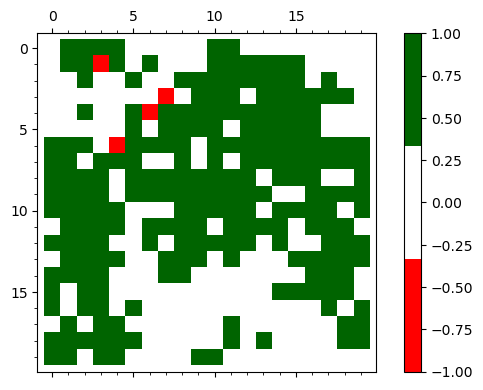

Current time: 40


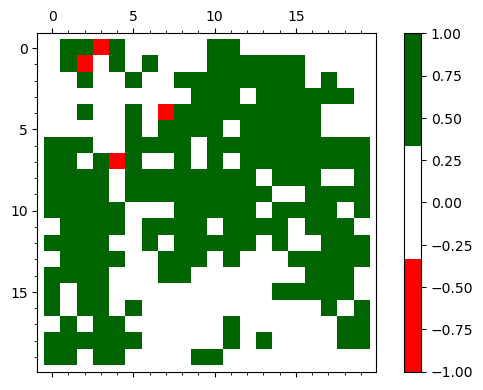

Current time: 41


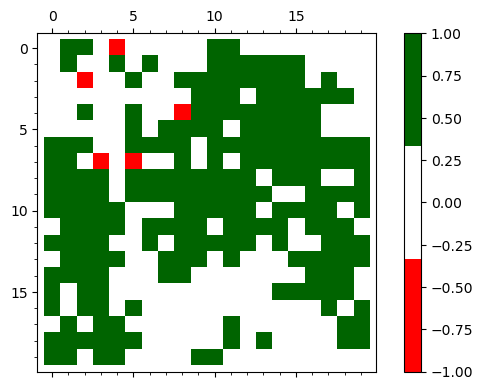

Current time: 42


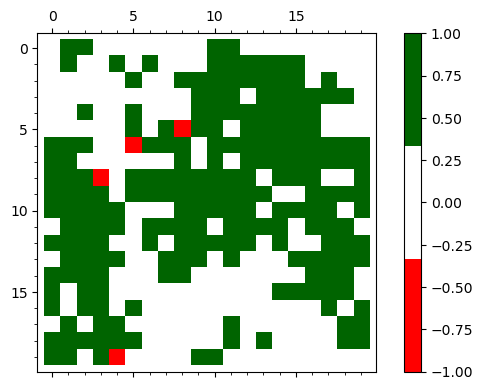

Current time: 43


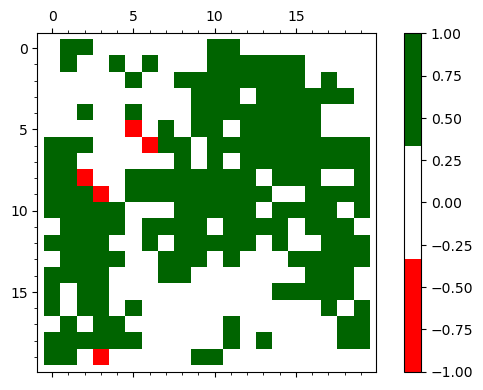

Current time: 44


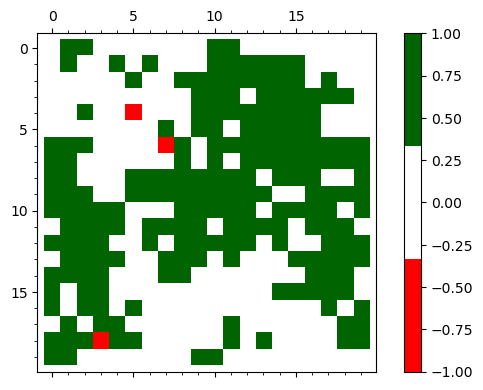

Current time: 45


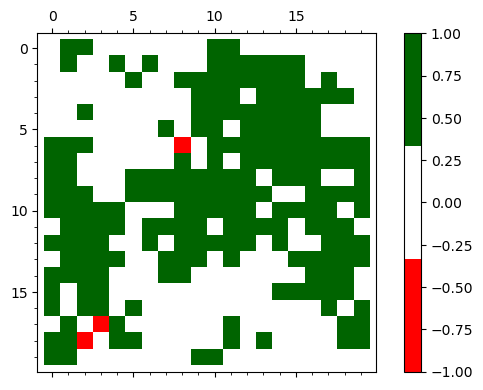

Current time: 46


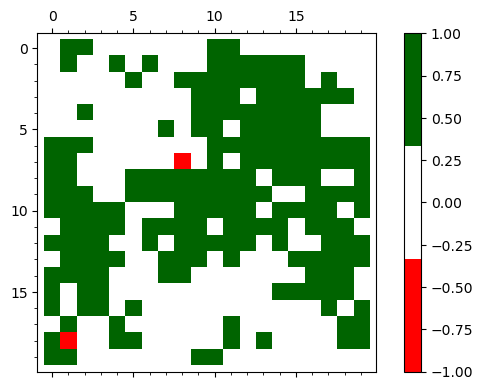

Current time: 47


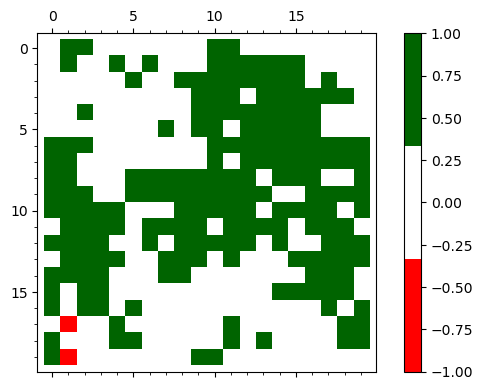

Current time: 48


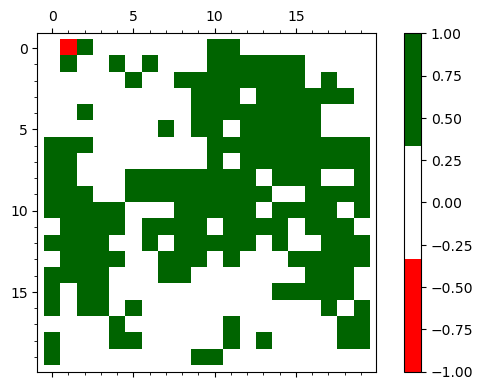

Current time: 49


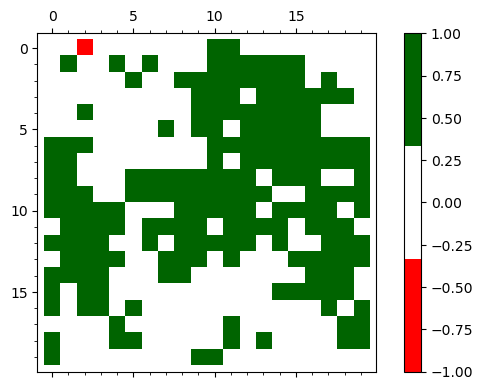

Current time: 50


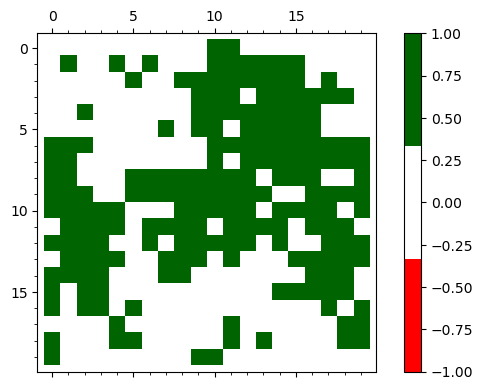

In [12]:
current_time = 1

# inital setup -> create trees and a intial fire
createTrees(density, free_fields, forest_fields, number_of_columns, number_of_rows, forest)
createInitialFire(forest_fields, fire_fields, forest)

# print start scene
print('Start scene:')
printMatrix(forest)

# run as long as we have forest fields, we have fires and the current time is less than 100
# without the last check it could be possible that we run into an infinite loop, because trees grow
# as fast as they durn down.

while(len(forest_fields) != 0 and len(fire_fields) != 0 and current_time < 100):

    # print a timestamp
    print('Current time: ' + str(current_time))

    # let the fire spread 
    spreadFire(forest_fields, fire_fields, free_fields, pe, forest, True, number_of_columns, number_of_rows)
    
    # create a lightning
    createLightningFire(forest_fields, fire_fields, free_fields, pb)
    
    # create new trees
    growTree(pw, free_fields, forest_fields, forest)
    
    # print matrix
    printMatrix(forest)

    current_time += 1

**Aufgabenstellung 3 - Statistikfunktionen**

`setupForAnalytics()` erstellt ein neues Setup für die Simulation. Hierfür werden vorerst alle Parameter zurückgesetzt. Anschließend werden wieder zufällig Bäume auf dem Gitternetz generiert und ein Startfeuer entzündet.

Diese Methode dient dazu, dass man für die die Statistikfunktionen eine neues Setup erzeugen kann.

In [13]:
def setupForAnalytics():

    # define lists for each category and clear them
    forest_fields.clear()
    fire_fields.clear()
    free_fields.clear()


    # create forest matrix
    forest = random_matrix(ZZ, nrows = number_of_rows, ncols = number_of_columns, x = 1)
    
    # fill list with free fields with all possible values
    for col in range(0, number_of_columns):
        for row in range(0, number_of_rows):
            free_fields.append((row, col))
    
    # create inital trees and fire
    createTrees(density, free_fields, forest_fields, number_of_columns, number_of_rows, forest)
    createInitialFire(forest_fields, fire_fields, forest)

`runAnalytics(pe, pb, pw, forest_fields, fire_fields, free_fields, forest, number_of_columns, number_of_rows, oneSystem)` lässt die Simulation über **ein** Setup laufen. Hierbei wird das grundlegende Setup verändert, daher ist es wichtig beim Aufruf dieser Methode nur Kopien der Listen und der Matrix zu übergeben. Somit ist sichergestellt, dass mehrere Analysevorgänge mit dem identischen Setup laufen können.

Des Weiteren wird eine `analytics` Liste geführt, welche die bis zu einem Zeitpunkt gebrannten Bäume aufsummiert. Dies wird dann anschließend an den Aufrufer zurückgegeben.

In [14]:
def runAnalytics(pe, pb, pw, forest_fields, fire_fields, free_fields, forest, number_of_columns, number_of_rows, oneSystem):
    current_time = 1
    
    # time 0 - one tree burns
    analytics = [(0,1)]
    
    # run as long as we have forest fields, we have fires and the current time is less than 100
    # without the last check it could be possible that we run into an infinite loop, because trees grow
    # as fast as they durn down.
    
    while(len(forest_fields) != 0 and len(fire_fields) != 0 and current_time < 100):
        
        # spread fire, create a lightning and new trees
        spreadFire(forest_fields, fire_fields, free_fields, pe, forest, oneSystem, number_of_columns, number_of_rows)
        createLightningFire(forest_fields, fire_fields, free_fields, pb)
        growTree(pw, free_fields, forest_fields, forest)
        
        # save current status of burned trees in analytics list
        current_status = (current_time, analytics[current_time-1][1] + len(fire_fields))
        analytics.append(current_status)

        current_time += 1
        
    return analytics

Dieser Codeblock generiert die Analysen zur Simulation. 

Hierbei wird die Simulation mit 5 verschiedenen Setups wiederholt. Das grundlegende Setup wird dabei nicht verändert, somit starten alle Simulationen auf der gleichen Datenbasis. Ziel ist es, zu vergleichen wie sich der Waldbrand in diesem Setup mit unterschiedlichen Wahrscheinlichkeiten ausbreitet. Ebenso werden auch die Anteile des abgebrannten Waldes zur Zeit als Plot ausgegeben.

Anpassungen können an der Wahrscheinlichkeit für Feuer, für einen Blitz und für einen neuen Baum angegeben werden. Ebenso kann man entscheiden welche Implementierung der Randfelder man benutzen möchte.

Setup: 1


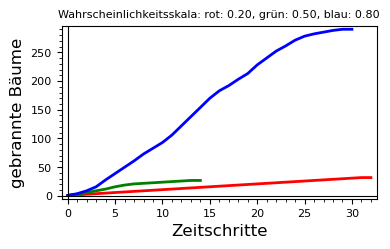

Setup: 2


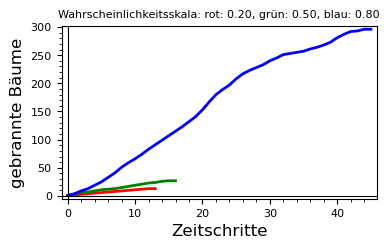

Setup: 3


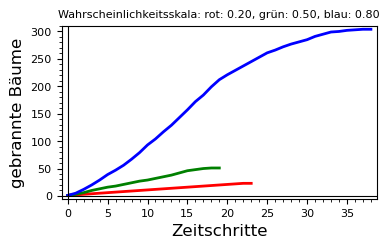

Setup: 4


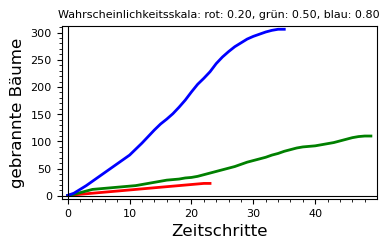

Setup: 5


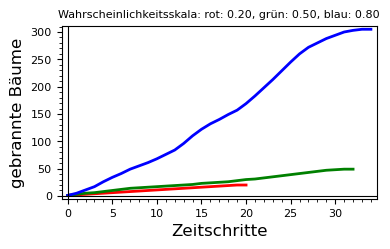

In [15]:
# run analytics -> 3 possibilities on one setup for 5 different setups

# amount of different setups
run = 5


while run > 0:
    
    # create intial setup
    setupForAnalytics()
    
    # run 3 simulations with different possibilities -> transmit only copies so that each possibiliy have the same initial setup
    analytics_20 = runAnalytics(0.2, 0, 0, forest_fields.copy(), fire_fields.copy(), free_fields.copy(), copy(forest), number_of_columns, number_of_rows, False)
    analytics_50 = runAnalytics(0.5, 0, 0, forest_fields.copy(), fire_fields.copy(), free_fields.copy(), copy(forest), number_of_columns, number_of_rows, False)
    analytics_80 = runAnalytics(0.8, 0, 0, forest_fields.copy(), fire_fields.copy(), free_fields.copy(), copy(forest), number_of_columns, number_of_rows, False)
    
    # collect all three lists in one plot
    g = Graphics()

    p20 = list_plot(analytics_20, plotjoined=True, title="Wahrscheinlichkeitsskala: rot: 0.20, grün: 0.50, blau: 0.80", frame=True, axes_labels=["Zeitschritte","gebrannte Bäume"], fontsize=8, color='red', thickness=2)
    p50 = list_plot(analytics_50, plotjoined=True, title="Wahrscheinlichkeitsskala: rot: 0.20, grün: 0.50, blau: 0.80", frame=True, axes_labels=["Zeitschritte","gebrannte Bäume"], fontsize=8, color='green', thickness=2)
    p80 = list_plot(analytics_80, plotjoined=True, title="Wahrscheinlichkeitsskala: rot: 0.20, grün: 0.50, blau: 0.80", frame=True, axes_labels=["Zeitschritte","gebrannte Bäume"], fontsize=8, color='blue', thickness=2)
        
    g = g + p20 + p50 + p80
    
    # print in which setup we are
    print('Setup: ' + str(6 - run))
    
    # print plot
    g.show(figsize=4)
    
    run -= 1


In diesem Abschnitt wird eine weitere Analyse durchgeführt. Hier wird nämlich die Anzahl abgebrannter Bäume zum Zeitpunkt 10 im Bezug auf die Wahrscheinlichkeit dargestellt.

Hierfür werden 5 verschiendene Setups generiert und jedes mit jeder Wahrscheinlichkeit von 0 - 1 für ein Feuer an einem Nachbarfeld simuliert. Anschließend wird die Anzahl an abgebrannten Bäumen am Zeitpunkt 10 ermittelt und gespeichert.

Im Plot sieht man dann wie viele Bäume in diesem Setup mit der entsprechend gewählten Wahrscheinlichkeit am Zeitpunkt 10 verbrannt sind. Dabei ist jedes Setup in einer anderen Farbe dargestellt.

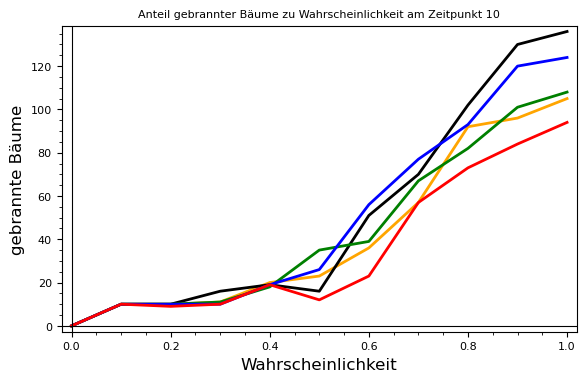

In [16]:
# amount of runs
run = 5

# graphic for plot
g = Graphics()

# different colors
colors = ['red', 'blue', 'green', 'black', 'orange']

while run > 0:
    
    # create a initial setup
    setupForAnalytics()

    # with possibility 0, 0 trees burn down at timestamp 10
    amount_to_pe = [(0,0)]

    # loop through all possibilites -> starting with 0.1 - ends with 1 - steps 0.1
    for i in range(1, 11):
        
        # calculate possibility
        pe = i / 10
        
        # run analytics
        analytics = runAnalytics(pe, 0, 0, forest_fields.copy(), fire_fields.copy(), free_fields.copy(), copy(forest), number_of_columns, number_of_rows, False)

        # check if run takes longer than 10 time units
        if(len(analytics) < 10):
            
            # if not -> take the last amount of burned trees
            amount_to_pe.append((pe, analytics[len(analytics)-1][1]))
            
        else:
            
            # if yes -> take amount of burned trees at timestamp 10
            amount_to_pe.append((pe, analytics[9][1]))


    # add list to plot
    plot = list_plot(amount_to_pe, plotjoined=True, title="Anteil gebrannter Bäume zu Wahrscheinlichkeit am Zeitpunkt 10", frame=True, axes_labels=["Wahrscheinlichkeit","gebrannte Bäume"], fontsize=8, color=colors[run - 1], thickness=2)
    g = g + plot
    
    run -= 1

# show plot
g.show()
    